# Simple dose computation and optimization on a real CT image

In [2]:
import numpy as np

from matplotlib import pyplot as plt

from opentps.core.data.images import CTImage
from opentps.core.data.images import ROIMask
from opentps.core.data.plan import PlanDesign
from opentps.core.data import DVH
from opentps.core.data import Patient
from opentps.core.io import mcsquareIO
from opentps.core.io.scannerReader import readScanner
from opentps.core.processing.doseCalculation.doseCalculationConfig import DoseCalculationConfig
from opentps.core.processing.doseCalculation.mcsquareDoseCalculator import MCsquareDoseCalculator
from opentps.core.processing.imageProcessing.resampler3D import resampleImage3DOnImage3D
from opentps.core.io.dataLoader import readData
from opentps.core.data.plan import ObjectivesList
from opentps.core.data.plan import FidObjective
from opentps.core.io.dicomIO import readDicomPlan, readDicomStruct
from opentps.core.data._rtStruct import RTStruct


In [3]:
ctCalibration = readScanner(DoseCalculationConfig().scannerFolder)
bdl = mcsquareIO.readBDL(DoseCalculationConfig().bdlFile)


ctImagePath = "../../../../testData/ANON242"
data = readData(ctImagePath)

../../../../testData/ANON242/CT/1.2.752.243.1.1.20200505084908775.4410.24626.dcm
../../../../testData/ANON242
../../../../testData/ANON242/CT/1.2.752.243.1.1.20200505084908790.4450.68202.dcm
../../../../testData/ANON242
../../../../testData/ANON242/CT/1.2.752.243.1.1.20200505084908806.4460.21660.dcm
../../../../testData/ANON242
../../../../testData/ANON242/CT/1.2.752.243.1.1.20200505084908822.4470.23354.dcm
../../../../testData/ANON242
../../../../testData/ANON242/CT/1.2.752.243.1.1.20200505084908838.4480.74408.dcm
../../../../testData/ANON242
../../../../testData/ANON242/CT/1.2.752.243.1.1.20200505084908854.4490.83234.dcm
../../../../testData/ANON242
../../../../testData/ANON242/CT/1.2.752.243.1.1.20200505084908870.4500.18883.dcm
../../../../testData/ANON242
../../../../testData/ANON242/CT/1.2.752.243.1.1.20200505084908885.4510.15326.dcm
../../../../testData/ANON242
../../../../testData/ANON242/CT/1.2.752.243.1.1.20200505084908901.4520.32584.dcm
../../../../testData/ANON242
../../../.

In [4]:
data[0].print_ROINames()
rt_struct  = data[0]
ct = data[2]


RT Struct UID: 1.2.752.243.1.1.20200505084910773.5740.87064
  [0]  External
  [1]  Mandible
  [2]  SpinalCord
  [3]  Parotid_R
  [4]  Parotid_L
  [5]  GTVn
  [6]  ConstrMusclePharynx Total
  [7]  Larynx
  [8]  Submandibular_R
  [9]  GTVp
  [10]  CTVnR_54Gy
  [11]  CTVnL_54Gy
  [12]  BrainStem
  [13]  Trachea
  [14]  OralCavity
  [15]  SpinalCord_PRV
  [16]  Brainstem_PRV
  [17]  Thyroid
  [18]  Lips
  [19]  CTVnL_69Gy
  [20]  CTVt_54Gy
  [21]  CTVt_69Gy
  [22]  PTVnL_54Gy
  [23]  PTVnR_54Gy
  [24]  PTVt_54Gy
  [25]  PTVt_69Gy
  [26]  Esophagus 2cm
  [27]  Esophagus 5cm
  [28]  ConstrMusclePharynx Sup
  [29]  ConstrMusclePharynx Moy
  [30]  ConstrMusclePharynx Inf
  [31]  ConstrMusclePharynx UES
  [32]  PTVnL_69Gy
  [33]  p+1
  [34]  p+.5
  [35]  n+.5
  [36]  tomostruct
  [37]  tomostruct 69Gy
  [38]  skin R
  [39]  skin L
  [40]  aide Mandible
  [41]  aide parotid_R
  [42]  aide Parotid_L
  [43]  aide larynx
  [44]  aide Submandibular_R
  [45]  aide Trachea
  [46]  aide OralCavity
  [

In [5]:
ROI_name = "PTVt_69Gy"
roi = rt_struct.getContourByName(ROI_name).getBinaryMask()

<class 'opentps.core.data.images._roiMask.ROIMask'>


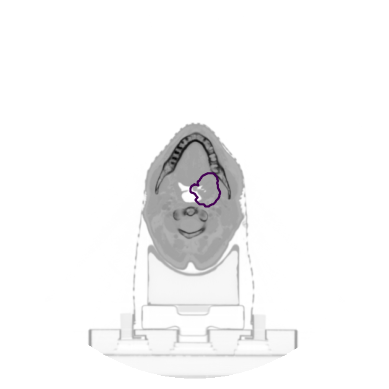

In [6]:
roi = resampleImage3DOnImage3D(roi, ct)
COM_coord = roi.centerOfMass
COM_index = roi.getVoxelIndexFromPosition(COM_coord)
Z_COORD = COM_index[2]
plt.imshow(ct.imageArray[:,:,Z_COORD].T,cmap='binary',vmin=-1024)
plt.contour(roi.imageArray[:,:,Z_COORD].T)
plt.axis("off")
print(type(roi))

In [7]:
# Configure MCsquare
mc2 = MCsquareDoseCalculator()
mc2.beamModel = bdl
mc2.ctCalibration = ctCalibration
mc2.nbPrimaries = 5e4
contour_name = 'External'
body_contour = rt_struct.getContourByName(contour_name)
mc2.overwriteOutsideROI = body_contour

In [8]:
# Design plan
beamNames = ["Beam1","Beam2","Beam3"]
gantryAngles = [0.,90.,270.]
couchAngles = [0.,0.,0.]

# Generate new plan
planDesign = PlanDesign()
planDesign.ct = ct
planDesign.gantryAngles = gantryAngles
planDesign.targetMask = roi
planDesign.beamNames = beamNames
planDesign.couchAngles = couchAngles
planDesign.calibration = ctCalibration
planDesign.spotSpacing = 5.0
planDesign.layerSpacing = 5.0
planDesign.targetMargin = 5.0

plan = planDesign.buildPlan()  # Spot placement
plan.PlanName = "NewPlan"

28/07/2023 12:16:20 PM - opentps.core.data.plan._planDesign - INFO - Building plan ...
28/07/2023 12:16:21 PM - opentps.core.processing.planOptimization.planInitializer - INFO - Target is dilated using a margin of 5.0 mm. This process might take some time.
28/07/2023 12:16:21 PM - opentps.core.processing.imageProcessing.roiMasksProcessing - INFO - Using SITK to dilate mask.
28/07/2023 12:16:49 PM - opentps.core.data.plan._planDesign - INFO - New plan created in 29.574003219604492 sec
28/07/2023 12:16:49 PM - opentps.core.data.plan._planDesign - INFO - Number of spots: 2090


In [9]:
beamlets = mc2.computeBeamlets(ct, plan,roi=[roi])
plan.planDesign.beamlets = beamlets
doseImageRef = beamlets.toDoseImage()

28/07/2023 12:16:53 PM - opentps.core.processing.doseCalculation.mcsquareDoseCalculator - INFO - Prepare MCsquare Beamlet calculation
28/07/2023 12:16:56 PM - opentps.core.io.mcsquareIO - INFO - Cropping CT around External
28/07/2023 12:16:57 PM - opentps.core.io.mhdIO - INFO - Write MHD file: /home/eliot/openTPS_workspace/Simulations/MCsquare_simulation/CT.mhd
28/07/2023 12:16:58 PM - opentps.core.io.mcsquareIO - INFO - Write plan: /home/eliot/openTPS_workspace/Simulations/MCsquare_simulation/PlanPencil.txt
28/07/2023 12:16:59 PM - opentps.core.processing.doseCalculation.mcsquareDoseCalculator - INFO - Start MCsquare simulation


MCsquare: 7: [: Linux: unexpected operator





Initialization time: 0.742453 s 


Simulation of beamlet 1018/2090  
MC computation time: 10.215495 s 
Output computation time: 0.833059 s 

Simulation of beamlet 722/2090  
MC computation time: 10.230027 s 
Output computation time: 0.833860 s 

Simulation of beamlet 1943/2090  
MC computation time: 10.727170 s 
Output computation time: 0.745071 s 

Simulation of beamlet 1314/2090  
MC computation time: 11.484641 s 
Output computation time: 0.769280 s 

Simulation of beamlet 1499/2090  
MC computation time: 12.192843 s 
Output computation time: 0.822569 s 

Simulation of beamlet 1092/2090  
MC computation time: 12.307824 s 
Output computation time: 0.886248 s 

Simulation of beamlet 1795/2090  
MC computation time: 12.426719 s 
Output computation time: 0.838371 s 

Simulation of beamlet 609/2090  
MC computation time: 12.980425 s 
Output computation time: 0.625142 s 

Simulation of beamlet 870/2090  
MC computation time: 12.856947 s 
Output computation time: 0.865963 s 

Simulation 

In [10]:
img_ct = ct.imageArray[:, :, Z_COORD].transpose(1, 0)
img_mask = roi.imageArray[:,:,Z_COORD]
img_dose = doseImageRef.imageArray[:, :, Z_COORD].transpose(1, 0)

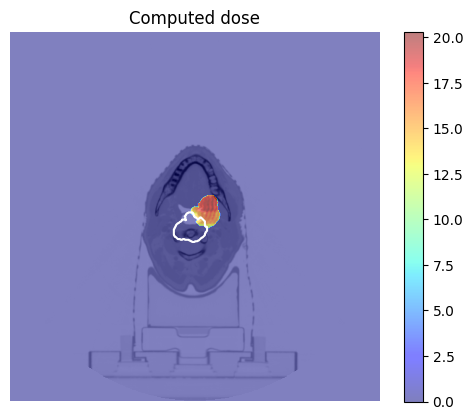

In [11]:
plt.imshow(img_ct, cmap='binary',vmin=-1024)
plt.contour(img_mask, cmap='binary')
dose = plt.imshow(img_dose, cmap='jet',alpha=.5)

plt.colorbar(dose)
plt.title("Computed dose")
plt.axis('off')

plt.show()

In [12]:
plan.planDesign.objectives = ObjectivesList() #create a new objective set
plan.planDesign.objectives.setTarget(roi.name, 20.0) #setting a target of 20 Gy for the target
plan.planDesign.objectives.fidObjList = []
plan.planDesign.objectives.addFidObjective(roi, FidObjective.Metrics.DMAX, 20.0, 1.0)
plan.planDesign.objectives.addFidObjective(roi, FidObjective.Metrics.DMIN, 20.0, 1.0)
plan.planDesign.defineTargetMaskAndPrescription()

In [19]:
from opentps.core.processing.planOptimization.planOptimization import IMPTPlanOptimizer
solver = IMPTPlanOptimizer(method='Gradient',plan=plan)
w, doseImage, ps = solver.optimize()

plan.spotMUs = np.square(w).astype(np.float32)

28/07/2023 01:01:31 PM - opentps.core.processing.planOptimization.planOptimization - INFO - Prepare optimization ...
28/07/2023 01:01:33 PM - opentps.core.processing.planOptimization.solvers.solver - INFO - Dummy objective function added
28/07/2023 01:01:36 PM - opentps.core.processing.planOptimization.solvers.gradientDescent - INFO - minimizing GradientDescent smooth functions.
28/07/2023 01:01:36 PM - opentps.core.processing.planOptimization.acceleration.baseAccel - INFO - dummy accel
28/07/2023 01:01:36 PM - opentps.core.processing.planOptimization.solvers.solver - INFO - Iteration 1 of GradientDescent:
28/07/2023 01:01:38 PM - opentps.core.processing.planOptimization.solvers.solver - INFO -     objective = 3.70e+01
28/07/2023 01:01:38 PM - opentps.core.processing.planOptimization.solvers.solver - INFO - Iteration 2 of GradientDescent:
28/07/2023 01:01:40 PM - opentps.core.processing.planOptimization.solvers.solver - INFO -     objective = 2.96e+01
28/07/2023 01:01:40 PM - opentps.c

In [14]:
finalDoseImage = mc2.computeDose(ct,plan)

28/07/2023 12:40:17 PM - opentps.core.processing.doseCalculation.mcsquareDoseCalculator - INFO - Prepare MCsquare Dose calculation
28/07/2023 12:40:17 PM - opentps.core.io.mcsquareIO - INFO - Cropping CT around External
28/07/2023 12:40:18 PM - opentps.core.io.mhdIO - INFO - Write MHD file: /home/eliot/openTPS_workspace/Simulations/MCsquare_simulation/CT.mhd
28/07/2023 12:40:18 PM - opentps.core.io.mcsquareIO - INFO - Write plan: /home/eliot/openTPS_workspace/Simulations/MCsquare_simulation/PlanPencil.txt
28/07/2023 12:40:20 PM - opentps.core.processing.doseCalculation.mcsquareDoseCalculator - INFO - Start MCsquare simulation


MCsquare: 7: [: Linux: unexpected operator





Initialization time: 0.731086 s 


Simulation started (2023-07-28 12:40:21) 
 10.0 % 
 20.0 % 
 30.0 % 
 40.0 % 
 50.0 % (stat uncertainty: 27.00 %) 
 60.0 % (stat uncertainty: 25.60 %) 
 70.0 % (stat uncertainty: 24.45 %) 
 80.0 % (stat uncertainty: 23.28 %) 
 90.0 % (stat uncertainty: 22.30 %) 
 100.0 % (stat uncertainty: 21.61 %) 

Nbr primaries simulated: 50080 
MC computation time: 12.645139 s 
Output computation time: 0.132509 s 

Total computation time: 13.533063 s 


In [15]:
img_ct = ct.imageArray[:, :, Z_COORD].transpose(1, 0)
img_mask = roi.imageArray[:,:,Z_COORD]
img_dose = finalDoseImage.imageArray[:, :, Z_COORD].transpose(1, 0)

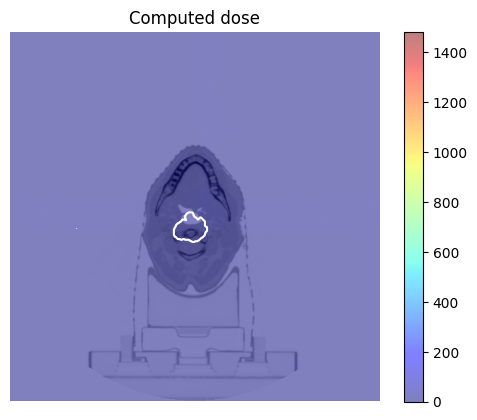

In [16]:
plt.imshow(img_ct, cmap='binary',vmin=-1024)
plt.contour(img_mask, cmap='binary')
dose = plt.imshow(img_dose, cmap='jet',alpha=.5)

plt.colorbar(dose)
plt.title("Computed dose")
plt.axis('off')

plt.show()